In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import pandas as pd 

#Reading in Excel sheet
df = pd.read_excel('Simulated Data - ICSI ML Project.xlsx' , header=1)

#Cleaning up Data
df = df.drop(columns='Patient_ID')
df.columns = df.columns.str.strip()
duplicates = df.columns[df.columns.duplicated()]
if not duplicates.empty:
    print("Duplicate columns names:" , duplicates.tolist())


#Defining columns
binary_cols = ['Round_Cells','Antisperm_Antibodies',
               'Sperm_Agglutination','Semen_Microbiology',
               'Blood_Microbiology','Hormonal_Stimulation']

multi_class_cols = ['Semen_Collection_Method','Viscosity',
                    'Male_Infertility','Varicocele',
                    'Male_Tobacco','Female_Tobacco',
                    'Male_Alcohol','Female_Alcohol']

target = 'Fertilization Rate (%)'
if target not in df.columns: 
    raise KeyError("check name of target again")

X = df.drop(columns=[target])
y = df[target]


In [2]:
print(X)
print(y)

      Blastulation_Rate (%) Semen_Collection_Method  \
0                        55            Masturbation   
1                        75            Masturbation   
2                        65            Masturbation   
3                        83            Masturbation   
4                        52            Masturbation   
...                     ...                     ...   
1495                     65                  Condom   
1496                     32        Partner Assisted   
1497                     38                  Condom   
1498                     37            Masturbation   
1499                     62            Masturbation   

      Ejaculatory_Abstinence (days)  Semen_Volume (ml)  Seminal_pH  \
0                                 4               4.56        7.72   
1                                 7               5.21        7.29   
2                                 4               2.16        7.63   
3                                 3               2.22     

In [6]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

#Splitting data into Train/Test/Cv Sets
X_temp , X_test , y_temp , y_test = train_test_split(
    X , y, test_size=0.2, random_state=42
)

X_train , X_cv , y_train, y_cv = train_test_split(
   X_temp , y_temp, test_size=0.25, random_state=42 
)

#Redefining numeric columns after the data has been split
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

#Defining the preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('bin' , OrdinalEncoder(),binary_cols),
        ('multi', OneHotEncoder(drop='first', sparse_output=False) , multi_class_cols),
        ('num', Pipeline(steps=[('scaler' , MinMaxScaler())]), numeric_cols)
    ])

x_train_transformed  = preprocessor.fit_transform(X_train)
x_cv_transformed = preprocessor.transform(X_cv)
x_test_transformed = preprocessor.transform(X_test)

x_train_df = pd.DataFrame(x_train_transformed, columns=preprocessor.get_feature_names_out())
x_cv_df = pd.DataFrame(x_cv_transformed, columns=preprocessor.get_feature_names_out())
x_test_df = pd.DataFrame(x_test_transformed, columns=preprocessor.get_feature_names_out())

# y_scaler = MinMaxScaler()
y_train_scaled = y_train /100.0  # y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_cv_scaled = y_cv/100.0        #y_scaler.transform(y_cv.values.reshape(-1, 1)).ravel()

print("Train set:" , X_train.shape)
print("CV set:" , X_cv.shape)
print("Test set:", X_test.shape)

print(x_train_df)
print(x_cv_df)

print(y_train_scaled)
print(y_cv_scaled)

Train set: (900, 40)
CV set: (300, 40)
Test set: (300, 40)
     bin__Round_Cells  bin__Antisperm_Antibodies  bin__Sperm_Agglutination  \
0                 1.0                        1.0                       4.0   
1                 0.0                        1.0                       3.0   
2                 1.0                        1.0                       0.0   
3                 0.0                        0.0                       4.0   
4                 0.0                        0.0                       0.0   
..                ...                        ...                       ...   
895               0.0                        0.0                       0.0   
896               0.0                        0.0                       1.0   
897               0.0                        1.0                       1.0   
898               0.0                        0.0                       1.0   
899               1.0                        1.0                       1.0   

    

Selected Features: ['num__Semen_Volume (ml)', 'num__Male_BMI (kg/m2)']
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END activation=relu, alpha=0.03, hidden_layer_sizes=(32, 16), learning_rate_init=0.03, max_iter=1000, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.03, hidden_layer_sizes=(32, 16), learning_rate_init=0.03, max_iter=1000, solver=adam; total time=   0.0s
[CV] END activation=relu, alpha=0.03, hidden_layer_sizes=(32, 16), learning_rate_init=0.03, max_iter=1000, solver=adam; total time=   0.0s
Best Features
{'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.03, 'max_iter': 1000, 'solver': 'adam'}
CV MSE: 310.98
CV MAE: 15.07
R² Score: -0.01


<Figure size 600x400 with 0 Axes>

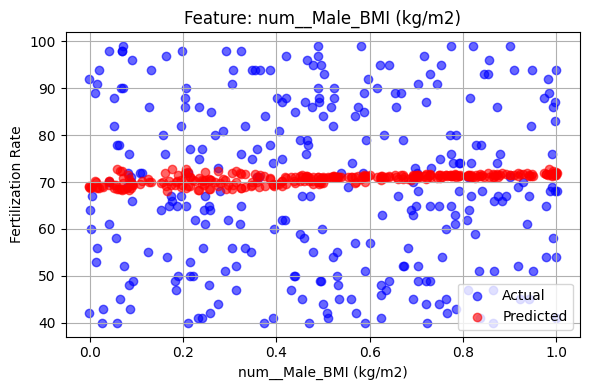

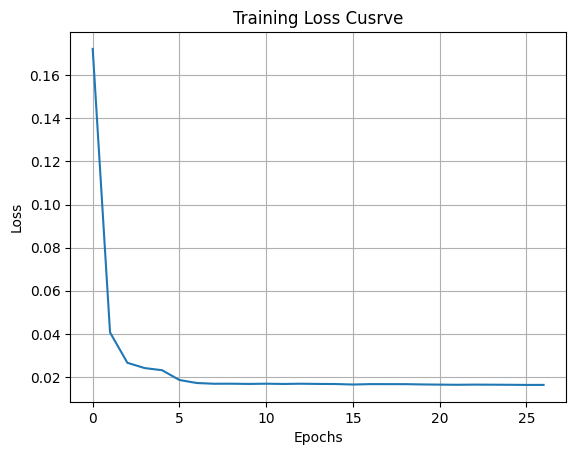

In [9]:
rfe_selector = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=2)
rfe_selector.fit(x_train_df, y_train_scaled)

top_features = x_train_df.columns[rfe_selector.support_]

print("Selected Features:", list(top_features))

X_train_selected = x_train_df[top_features]
X_cv_selected = x_cv_df[top_features]
X_test_selected = x_test_df[top_features]

param_grid={
    'hidden_layer_sizes': [(32,16)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.03],
    'learning_rate_init': [0.03],
    'max_iter': [1000],
}

nn_model = MLPRegressor(random_state=42)

grid_search = GridSearchCV(nn_model , param_grid , cv=3,n_jobs=1 , verbose=2)

grid_search.fit(X_train_selected , y_train_scaled)

best_model = grid_search.best_estimator_
print("Best Features")
print(grid_search.best_params_)

y_cv_pred_scaled = best_model.predict(X_cv_selected)
y_cv_pred = y_cv_pred_scaled*100.0 #y_scaler.inverse_transform(y_cv_pred_scaled.reshape(-1,1)).ravel()

mse = mean_squared_error(y_cv, y_cv_pred)
mae = mean_absolute_error(y_cv, y_cv_pred)
r2 = r2_score(y_cv , y_cv_pred)


print(f"CV MSE: {mse:.2f}")
print(f"CV MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Loop over features
for feature in X_cv_selected.columns:
    plt.figure(figsize=(6, 4))
    
# X = feature values, Y = actual & predicted
plt.scatter(X_cv_selected[feature], y_cv, color='blue', label='Actual', alpha=0.6)
plt.scatter(X_cv_selected[feature], y_cv_pred, color='red', label='Predicted', alpha=0.6)

plt.title(f"Feature: {feature}")
plt.xlabel(feature)
plt.ylabel("Fertilization Rate")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# 11. Loss curveeeeee
best_model = grid_search.best_estimator_
plt.plot(best_model.loss_curve_)
plt.title("Training Loss Cusrve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [11]:
!git add Predict_Fertalisation.ipynb